How did smartphone prices change in the 2 months bracketing the election
and the inauguration in the past 2 presidential election cycles?



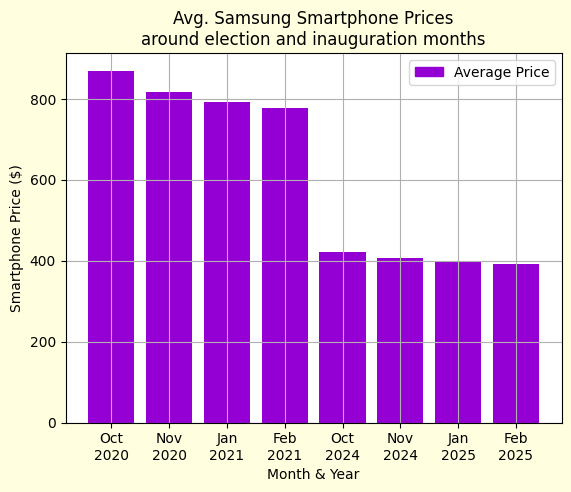



How did laptop prices change in the 2 months bracketing the election
and the inauguration in the past 2 presidential election cycles?



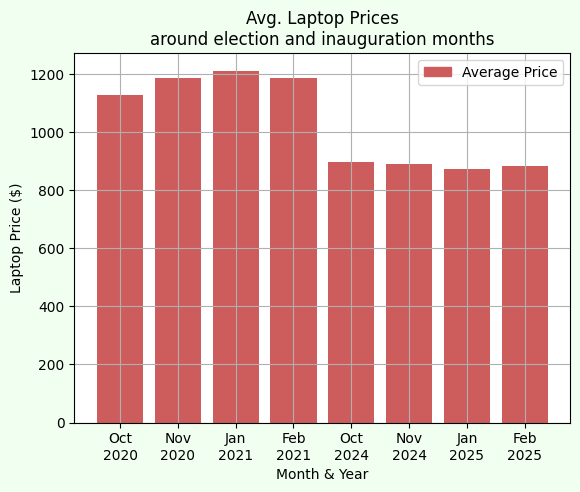



How did smartphone and laptop price shifts correlate with changes
in  microprocessor / CPU prices in the 2 months bracketing the election and
inauguration in the past 2 presidential election cycles?


Changes in CPU & Microprocessor Prices over this time frame:




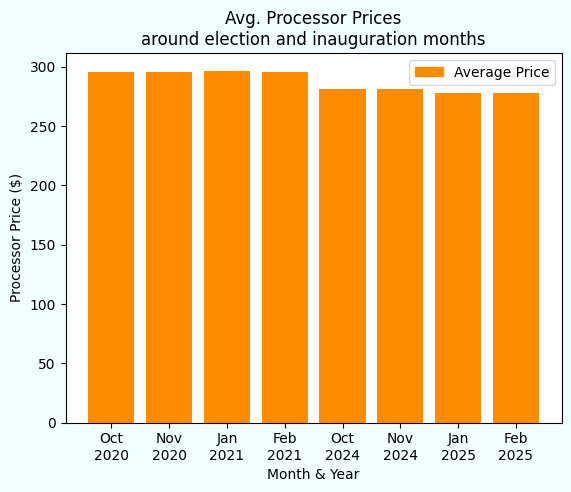

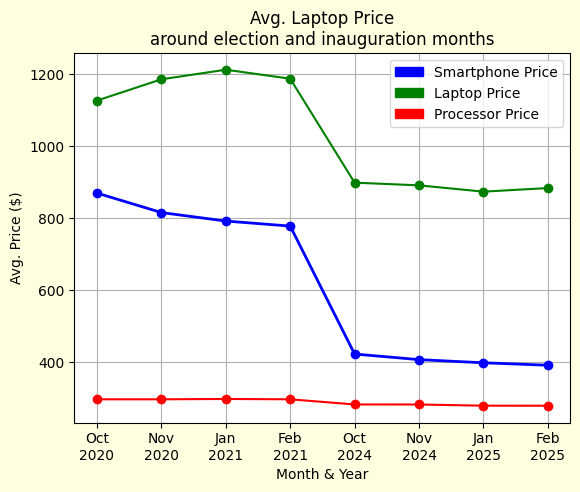

In [1]:
# Group Data Project Question 2 - Author: Nora Temkin
import urllib.request, urllib.parse, urllib.error, json
import re
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mplpatches
import pdb

# Data Project Question 1: how did smartphone prices change in the 2 months bracketing
## the election and the inauguration in the past 2 presidential election cycles?
### Data sources: the Bureau of Labor Statistics' Consumer Price Index for series 'Smartphones',
#### and Samsung's archived price data for Jan. 2020

# Data Project Question 2: how did laptop & tablet prices change in the 2 months bracketing
## the election and the inauguration in the past 2 presidential election cycles?
### Data sources: the Bureau of Labor Statistics' Consumer Price Index for
#### series 'Laptops, Tablets, & Portable Computers' and archived price data
##### for all available laptops on gadgetsc.com for Jan. 2020 (from Scribd)

# Data Project Question 3: do price changes in laptops seem to correlate more
### closely with price changes in microprocessors over the same time period, 
#### or with election results?
##### Data Sources: BLS Producer Price Index for Series 'Integrated Circuit
###### Packages, Including Microprocessors' and archived price data for CPUs from
####### AMT_CPU Product Price List (Scribd), w/prices converted to USD from MYR

def get_df_from_csv(filename):
    try:
        data_df = pd.read_csv(filename)
        return data_df
    except IOError:
        print("Error opening csv file. Could not create DataFrame.")
        return None

# def merge_csvs_single_cat(file_list, col_list):     # after init. testing, pass in [col_list]
#     target_hts8 = 85423100  # HTS-8 code for Electronic Circuits: Processors & Controllers in Tariff DBs
#     data_dict = {}
#     for file in file_list:
#         temp_df = pd.read_csv(file)
#         # print(temp_df.dtypes)
#         filtered_hts8_df = temp_df.loc[temp_df['hts8'] == target_hts8, col_list]
#         print(filtered_hts8_df.head(3))
#         # data_dict['']

def find_ppi_base_price(price_df, ppi_df, ppi_datestr):
    # coefficient = 100 / ppi_df.loc[ppi_df['observation_date'] == ppi_datestr, 'WPU117839']
    # avg_base_price = round(coefficient * price_df['Bundle_Price'].mean(), 2)
    avg_base_price = round(price_df['Bundle_Price'].mean(), 2)
    return avg_base_price

def find_cpi_base_price(price_df, cpi_df, cpi_month, yr_offset):
    bkwds_coefficient = 100 / cpi_df.loc[cpi_df.index[0 + yr_offset], cpi_month]
    if 'PRICE' in price_df:
        price_df.rename(columns={'PRICE': 'MSRP'}, inplace=True)
    avg_base_price = round(bkwds_coefficient * price_df['MSRP'].mean(), 2)
    return avg_base_price

def build_ppi_compare_list(ppi_df, base_price, base_yr, yr_month_tuplist, base_datestr):
    date_dict = {'Oct': '10/1', 'Nov': '11/1', 'Jan': '1/1', 'Feb': '2/1'}
    # pdb.set_trace()
    coefficient = 100 / ppi_df.loc[ppi_df['observation_date'] == base_datestr, 'WPU117839']
    price_compare_tuplist = []
    i = 0
    for time in yr_month_tuplist:
        year = time[0]
        date_txt = date_dict[time[1]]
        month = [time[1]]
        full_date_str = f"{date_txt}/{str(year)}"
        ppi_series = ppi_df.loc[ppi_df['observation_date'] == full_date_str]['WPU117839']
        ppi_series.index = [i]
        ppi_to_adj = ppi_series[i]
        adjusted_ppi = round(coefficient * ppi_to_adj, 2)
        price_series = round(base_price * (adjusted_ppi / 100), 2)
        price_series.index = [i]
        price = price_series[i]
        date_str = month[0] + '\n' + str(year)
        price_compare_tuplist.append((date_str, price))
    return price_compare_tuplist

def build_cpi_compare_list(cpi_df, base_price, base_yr, yr_month_tuplist):
    price_compare_tuplist = []
    for time in yr_month_tuplist:
        year = time[0]
        month = time[1]
        price = round(base_price * (cpi_df.loc[cpi_df.index[year - base_yr], month] / 100), 2)
        price_compare_tuplist.append((month + '\n' + str(year), price))
    return price_compare_tuplist

def merge_price_tuplists(list_of_tls):
    # list_of_tls = [tl1[(m,p), (m,p), (m,p), (m,p)], tl2[(m,p)] (m,p), (m,p), (m,p)], ...]
    merged_ptl = [] # Holds tuples w/ months + price from ea. tuplist in list_of_tls for each month
    tuple_builder = []
    tl_count = len(list_of_tls) # How many price lists (lists of tuples) are there?
    tl_length = len(list_of_tls[0]) # How many tuples are in a price list?
    prev_length = tl_length
    for tuplist in list_of_tls:
        if len(tuplist) != prev_length:
            print("Error: cannot merge tuple lists of different lengths.")
            return None
        else:
            prev_length = len(tuplist)
    for tup_num in range(tl_length):
        tuple_builder.append(list_of_tls[0][tup_num][0])    # Add month from current tuple in 1st tuplist
        for list_num in range(tl_count):    # Add price from current tuple in each tuplist
            tuple_builder.append(list_of_tls[list_num][tup_num][1])
        merged_ptl.append(tuple(tuple_builder)) # Turn tuple_builder list into tuple & append to merged_ptl
        tuple_builder.clear()
    return merged_ptl

def phone_price_compare_bargraph(prices_tuplist):
    fig, ax = plt.subplots()
    plt.title('Avg. Samsung Smartphone Prices\naround election and inauguration months')
    fig.set_facecolor('lightyellow')
    for month in prices_tuplist:
        ax.bar(month[0], month[1], color='darkviolet')
    price_patch = mplpatches.Patch(color='darkviolet', label='Average Price')
    ax.legend(handles=[price_patch], loc='upper right')
    ax.set_xlabel('Month & Year')
    ax.set_ylabel('Smartphone Price ($)')
    ax.grid()
    plt.show()
    print()
    fig.savefig('Election_Smartphone_Prices_Bar.jpg')

def laptop_price_compare_bargraph(prices_tuplist):
    fig, ax = plt.subplots()
    plt.title('Avg. Laptop Prices\naround election and inauguration months')
    fig.set_facecolor('honeydew')
    for month in prices_tuplist:
        ax.bar(month[0], month[1], color='indianred')
    price_patch = mplpatches.Patch(color='indianred', label='Average Price')
    ax.legend(handles=[price_patch], loc='upper right')
    ax.set_xlabel('Month & Year')
    ax.set_ylabel('Laptop Price ($)')
    ax.grid()
    plt.show()
    print()
    fig.savefig('Election_Laptop_Prices_Bar.jpg')

def cpu_price_bargraph(prices_tuplist):
    fig, ax = plt.subplots()
    plt.title('Avg. Processor Prices\naround election and inauguration months')
    fig.set_facecolor('azure')
    for month in prices_tuplist:
        ax.bar(month[0], month[1], color='darkorange')
    price_patch = mplpatches.Patch(color='darkorange', label='Average Price')
    ax.legend(handles=[price_patch], loc='upper right')
    ax.set_xlabel('Month & Year')
    ax.set_ylabel('Processor Price ($)')
    fig.savefig('Election_Processor_Prices_Bar.jpg')

def three_prod_price_linegraph(all_items_price_tuplist):  
    fig, ax = plt.subplots()
    plt.title('Avg. Laptop Price\naround election and inauguration months')
    fig.set_facecolor('lightyellow')
    x_list = [month[0] for month in all_items_price_tuplist]
    sp_y_list = [month[1] for month in all_items_price_tuplist]
    lt_y_list = [month[2] for month in all_items_price_tuplist]
    cpu_y_list = [month[3] for month in all_items_price_tuplist]
    ax.plot(x_list, sp_y_list, 'o-', linewidth=2.0, color='blue')
    ax.plot(x_list, lt_y_list, linestyle='-', marker='o', color='green')
    ax.plot(x_list, cpu_y_list, linestyle='-', marker='o', color='red')
    sm_patch = mplpatches.Patch(color='blue', label='Smartphone Price')
    lt_patch = mplpatches.Patch(color='green', label='Laptop Price')
    cpu_patch = mplpatches.Patch(color='red', label='Processor Price')
    ax.legend(handles=[sm_patch, lt_patch, cpu_patch], loc='upper right')
    # ax.legend(handles=[price_patch], loc='upper right')
    ax.set_xlabel('Month & Year')
    ax.set_ylabel('Avg. Price ($)')
    ax.grid()
    plt.show()
    print()
    fig.savefig('Election_Electronics_Prices_Line.jpg')

# Main execution area
target_months = [(2020, 'Oct'), (2020, 'Nov'), (2021, 'Jan'), (2021, 'Feb'), \
                 (2024, 'Oct'), (2024, 'Nov'), (2025, 'Jan'), (2025, 'Feb')]
# Question 1:
print('How did smartphone prices change in the 2 months bracketing the ' \
      + 'election\nand the inauguration in the past 2 presidential ' \
      + 'election cycles?\n')
cpi_sp_filename = '/content/drive/MyDrive/Colab Notebooks/SeriesReport-SmartPhone-CPI-2019-2025-Data-Only.csv'
sp_pricelist_filename = '/content/drive/MyDrive/Colab Notebooks/SeriesReport-SmartPhone-CPI-2019-2025_Jan2020Prices.csv'
# cpi_smartphones_df = get_df_from_csv(cpi_sp_filename)
# smsg_prices_2020_df = get_df_from_csv(sp_pricelist_filename)
cpi_smartphones_df = get_df_from_csv('SeriesReport-SmartPhone-CPI-2019-2025-Data-Only.csv')
smsg_prices_2020_df = get_df_from_csv('SeriesReport-SmartPhone-CPI-2019-2025_Jan2020Prices.csv')
smsg_prices_2020_df['UPC'] = round(smsg_prices_2020_df['UPC'], 0).astype(str)
sp_base_price = find_cpi_base_price(smsg_prices_2020_df, cpi_smartphones_df, 'Jan', 1)
sp_pricelist_by_month = build_cpi_compare_list(cpi_smartphones_df, sp_base_price, 2019, target_months)
phone_price_compare_bargraph(sp_pricelist_by_month)
print()

# Question 2:
print('How did laptop prices change in the 2 months bracketing the election\n' \
      + 'and the inauguration in the past 2 presidential election cycles?\n')
cpi_lt_filename = '/content/drive/MyDrive/Colab Notebooks/SeriesReport-LaptopsTabletsPortableComputers-BaseIsFeb2023.csv'
lt_pricelist_filename = '/content/drive/MyDrive/Colab Notebooks/476124375-Laptop-Pricelist-Jan-2020.csv'
# cpi_laptops_df = get_df_from_csv(cpi_lt_filename)
# laptop_prices_2020_df = get_df_from_csv(lt_pricelist_filename)
cpi_laptops_df = get_df_from_csv('SeriesReport-LaptopsTabletsPortableComputers-BaseIsFeb2023.csv')
laptop_prices_2020_df = get_df_from_csv('476124375-Laptop-Pricelist-Jan-2020.csv')
lt_avg_base_price = find_cpi_base_price(laptop_prices_2020_df, cpi_laptops_df, 'Jan', 1)
lt_pricelist_by_month = build_cpi_compare_list(cpi_laptops_df, lt_avg_base_price, 2019, target_months)
laptop_price_compare_bargraph(lt_pricelist_by_month)
print()

# Question 3:
print('How did smartphone and laptop price shifts correlate with changes\nin  ' \
      + 'microprocessor / CPU prices in the 2 months bracketing the election ' \
      + 'and\ninauguration in the past 2 presidential election cycles?\n')
print('\nChanges in CPU & Microprocessor Prices over this time frame:')
ppi_circuits_filename = '/content/drive/MyDrive/Colab Notebooks/FRED_PPI_Circuits and Microprocessors_2019 to 2020.csv'
cpu_pricelist_filename = '/content/drive/MyDrive/Colab Notebooks/471446431-AMT-CPU-Product-Price-List-Jan-2020.csv'
# ppi_circuits_df = get_df_from_csv(ppi_circuits_filename)
# cpu_prices_df = get_df_from_csv(cpu_pricelist_filename)
ppi_circuits_df = get_df_from_csv('FRED_PPI_Circuits and Microprocessors_2019 to 2020.csv')
cpu_prices_df = get_df_from_csv('471446431-AMT-CPU-Product-Price-List-Jan-2020.csv')
base_price_datestr = '1/1/2019'
cpu_avg_base_price = find_ppi_base_price(cpu_prices_df, ppi_circuits_df, base_price_datestr)
cpu_pricelist_by_month = build_ppi_compare_list(ppi_circuits_df, 
                                                cpu_avg_base_price, 2019, 
                                                target_months, 
                                                base_price_datestr)
cpu_price_bargraph(cpu_pricelist_by_month)
print()
all_cats_pricelists = [sp_pricelist_by_month, lt_pricelist_by_month, cpu_pricelist_by_month]
all_items_prices = merge_price_tuplists(all_cats_pricelists)
print()
three_prod_price_linegraph(all_items_prices)